In [ ]:
import os
import shutil
import random
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

import torchvision.transforms as T
import torchvision.datasets as dset
import torchvision.models as models

from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, classification_report, roc_curve


using_platform = 'colab'

dataset_path = None
if using_platform == 'colab':
    import kagglehub
    dataset_path = kagglehub.dataset_download("jagachau/weather-dataset")
    dataset_path = os.path.join(dataset_path, 'weather_dataset')
elif using_platform == 'kaggle':
    dataset_path = '/kaggle/input/weather-dataset/weather_dataset'
else:
    print('invalid platform')

print('dataset path:', dataset_path)

seed = 4471
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

moved = False

# For precise error position
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('using device:', device)
print('GPU count:', torch.cuda.device_count())

dataset path: /kaggle/input/weather-dataset/weather_dataset
using device: cuda
GPU count: 1


In [ ]:
classes = ['snow', 'rime', 'glaze', 'frost']
num_classes = len(classes)

dset_path = 'dataset'

if not moved:
	os.makedirs(dset_path, exist_ok=True)
	for c in classes:
		try:
			shutil.move(os.path.join(dataset_path, c), dset_path)
		except:
			...
	moved = True

print("Images count")

total = 0
class_counts = []
for weather in classes:
	count = len(os.listdir(os.path.join(dset_path, weather)))
	total += count
	class_counts.append(count)
	print(f"{weather:9} : {count:4}")

print(f"Total: {num_classes} classes with {total} images")

Images count
snow      :  621
rime      : 1160
glaze     :  639
frost     :  475
Total: 4 classes with 2895 images


In [ ]:
def split_dataset(altered_dataset, original_dataset, train_ratio=0.8, batch_size=64):
	workers = torch.cuda.device_count() * 2 if torch.cuda.device_count() else 1
	targets = np.array(altered_dataset.targets)

	# Split per class
	train_indices = []
	val_indices = []

	for class_idx in range(len(classes)):
		class_indices = np.where(targets == class_idx)[0]
		class_size = len(class_indices)

		train_size = int(train_ratio * class_size)

		train_idx, val_idx = train_test_split(
			class_indices,
			train_size=train_size,
			random_state=seed
		)

		train_indices.extend(train_idx)
		val_indices.extend(val_idx)

	train_dataset = Subset(altered_dataset, train_indices)
	val_dataset = Subset(original_dataset, val_indices)

	train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
	val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=workers)

	print(f"Train set size: {len(train_dataset)}")
	print(f"Validation set size: {len(val_dataset)}")

	return train_loader, val_loader

In [ ]:
resnet_mean = [0.485, 0.456, 0.406]
resnet_sd = [0.229, 0.224, 0.225]

transform_train = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15), 
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05), 
    T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    T.RandomResizedCrop(size=224, scale=(0.85, 1.0)), 
    T.ToTensor(),
    T.Normalize(mean=resnet_mean, std=resnet_sd)
])

transform_val = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=resnet_mean, std=resnet_sd)
])

altered_dataset = dset.ImageFolder(root=dset_path, transform=transform_train)
original_dataset = dset.ImageFolder(root=dset_path, transform=transform_val)
print(original_dataset.classes)

train_loader, val_loader = split_dataset(altered_dataset, original_dataset, 0.8, 64)

['frost', 'glaze', 'rime', 'snow']
Train set size: 2315
Validation set size: 580


In [ ]:
def get_model():
	model = models.resnet50(weights='DEFAULT')

	num_features = model.fc.in_features
	model.fc = nn.Linear(num_features, num_classes)
	model.to(device)

	for param in model.parameters():
		param.requires_grad = False
		
	for param in model.layer4.parameters():
		param.requires_grad = True
	for param in model.layer3.parameters():
		param.requires_grad = True
	for param in model.fc.parameters():
		param.requires_grad = True

	return model

def train_model(model, train_loader, val_loader, optimizer, scheduler, epochs, criterion):
	best_val_acc = 0
	best_model_state = None
	patience = 7
	patience_counter = 0
		
	train_losses, val_losses = [], []
	train_accs, val_accs = [], []

	for e in range(epochs):
		# Training
		model.train()
		train_loss = 0.0
		correct = 0
		total = 0
		batch_bar = tqdm(train_loader, desc=f"Epoch {e+1}: Train")
		for x, y in batch_bar:
			x, y = x.to(device), y.to(device)

			scores = model(x)
			loss = criterion(scores, y)

			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			train_loss += loss.item()
			_, predicted = torch.max(scores, 1)
			total += y.size(0)
			correct += (predicted == y).sum().item()

			batch_acc = 100 * correct / total
			batch_bar.set_postfix({"Train loss": f"{train_loss/len(batch_bar):.4f}", "Train acc": f"{batch_acc:.2f}%"})


		scheduler.step()
		train_acc = 100 * correct / total
		train_accs.append(train_acc)
		avg_train_loss = train_loss / len(train_loader)
		train_losses.append(avg_train_loss)

		# Validation
		model.eval()
		val_loss = 0.0
		correct = 0
		total = 0
		with torch.no_grad():
			batch_bar = tqdm(val_loader, desc=f"Epoch {e+1}: Validation")
			for x, y in batch_bar:
				x, y = x.to(device), y.to(device)
				scores = model(x)
				loss = criterion(scores, y)
				val_loss += loss.item()
				_, predicted = torch.max(scores, 1)
				total += y.size(0)
				correct += (predicted == y).sum().item()
				batch_acc = 100 * correct / total
				batch_bar.set_postfix({"Val loss": f"{val_loss/len(batch_bar):.4f}", "Val acc": f"{batch_acc:.2f}%"})

		val_acc = 100 * correct / total
		val_accs.append(val_acc)
		avg_val_loss = val_loss / len(val_loader)
		val_losses.append(avg_val_loss)

		# Save best model
		if val_acc > best_val_acc:
			best_val_acc = val_acc
			best_model_state = model.state_dict().copy()
			print(f"New best model with validation accuracy: {val_acc:.2f}%")
			patience_counter = 0
		else:
			patience_counter += 1
			
		# Early stopping
		if patience_counter >= patience:
			print(f"Early stopping at epoch {e+1}")
			break
			
		# Update scheduler with validation accuracy
		if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
			scheduler.step(val_acc)
		else:
			scheduler.step()
		
	if best_model_state is not None:
		model.load_state_dict(best_model_state)
		print(f"Loaded best model with validation accuracy: {best_val_acc:.2f}%")
		
	return train_losses, val_losses, train_accs, val_accs

def loss_acc_plot(train_losses, val_losses, train_accs, val_accs):
	# Plot loss
	plt.figure(figsize=(8, 6))
	plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
	plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
	plt.xlabel('Epoch')
	plt.ylabel('Loss')
	plt.title('Training and Validation Loss')
	plt.legend()
	plt.grid(True)
	plt.tight_layout()
	plt.show()

	# Plot accuracy
	plt.figure(figsize=(8, 6))
	plt.plot(range(1, len(train_accs) + 1), train_accs, label='Training Accuracy', marker='o')
	plt.plot(range(1, len(val_accs) + 1), val_accs, label='Validation Accuracy', marker='o')
	plt.xlabel('Epoch')
	plt.ylabel('Accuracy (%)')
	plt.title('Training and Validation Accuracy')
	plt.legend()
	plt.grid(True)
	plt.tight_layout()
	plt.show()

def inference(model, loader):
	model.eval()
	correct = 0
	total = 0
	with torch.no_grad():
		for inputs, labels in tqdm(loader, desc='Inference'):
			inputs, labels = inputs.to(device), labels.to(device)
			outputs = model(inputs)
			_, predicted = torch.max(outputs, 1)
			total += labels.size(0)
			correct += (predicted == labels).sum().item()
	test_acc = 100 * correct / total
	print(f"Accuracy: {test_acc:.2f}%")

def get_predictions_and_probs(model, loader):
	model.eval()
	all_labels, all_preds, all_probs = [], [], []
	with torch.no_grad():
		for inputs, labels in tqdm(loader, desc="Loading"):
			inputs, labels = inputs.to(device), labels.to(device)
			outputs = model(inputs)
			probs = torch.softmax(outputs, dim=1)
			_, preds = torch.max(probs, 1)
			all_labels.extend(labels.cpu().numpy())
			all_preds.extend(preds.cpu().numpy())
			all_probs.extend(probs.cpu().numpy())
	return np.array(all_labels), np.array(all_preds), np.array(all_probs)

def get_class_weights(class_counts):
	class_counts = np.array(class_counts)
	class_weights = 1.0 / class_counts
	class_weights = class_weights / class_weights.sum() * len(class_counts)
	return torch.tensor(class_weights, dtype=torch.float32, device=device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 88.4MB/s]
Epoch 1: Validation: 100%|██████████| 10/10 [00:02<00:00,  3.71it/s, Val loss=0.8778, Val acc=63.28%]


New best model with validation accuracy: 63.28%


Epoch 2: Validation: 100%|██████████| 10/10 [00:02<00:00,  3.77it/s, Val loss=0.6653, Val acc=73.97%]


New best model with validation accuracy: 73.97%


Epoch 3: Validation: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s, Val loss=0.5761, Val acc=78.62%]


New best model with validation accuracy: 78.62%


Epoch 4: Validation: 100%|██████████| 10/10 [00:02<00:00,  3.98it/s, Val loss=0.5325, Val acc=79.66%]


New best model with validation accuracy: 79.66%


Epoch 5: Validation: 100%|██████████| 10/10 [00:02<00:00,  3.97it/s, Val loss=0.4804, Val acc=81.21%]


New best model with validation accuracy: 81.21%


Epoch 6: Validation: 100%|██████████| 10/10 [00:02<00:00,  3.92it/s, Val loss=0.4618, Val acc=82.93%]


New best model with validation accuracy: 82.93%


Epoch 7: Validation: 100%|██████████| 10/10 [00:02<00:00,  3.72it/s, Val loss=0.4453, Val acc=84.31%]


New best model with validation accuracy: 84.31%


Epoch 8: Validation: 100%|██████████| 10/10 [00:02<00:00,  3.82it/s, Val loss=0.4319, Val acc=84.48%]


New best model with validation accuracy: 84.48%


Epoch 10: Validation: 100%|██████████| 10/10 [00:02<00:00,  3.75it/s, Val loss=0.4150, Val acc=84.66%]


New best model with validation accuracy: 84.66%


Epoch 13: Validation: 100%|██████████| 10/10 [00:02<00:00,  3.94it/s, Val loss=0.4092, Val acc=85.00%]


New best model with validation accuracy: 85.00%


Epoch 19: Validation: 100%|██████████| 10/10 [00:02<00:00,  3.99it/s, Val loss=0.3921, Val acc=85.52%]


New best model with validation accuracy: 85.52%


Epoch 26: Validation: 100%|██████████| 10/10 [00:02<00:00,  3.76it/s, Val loss=0.3914, Val acc=84.83%]


Early stopping at epoch 26
Loaded best model with validation accuracy: 85.52%


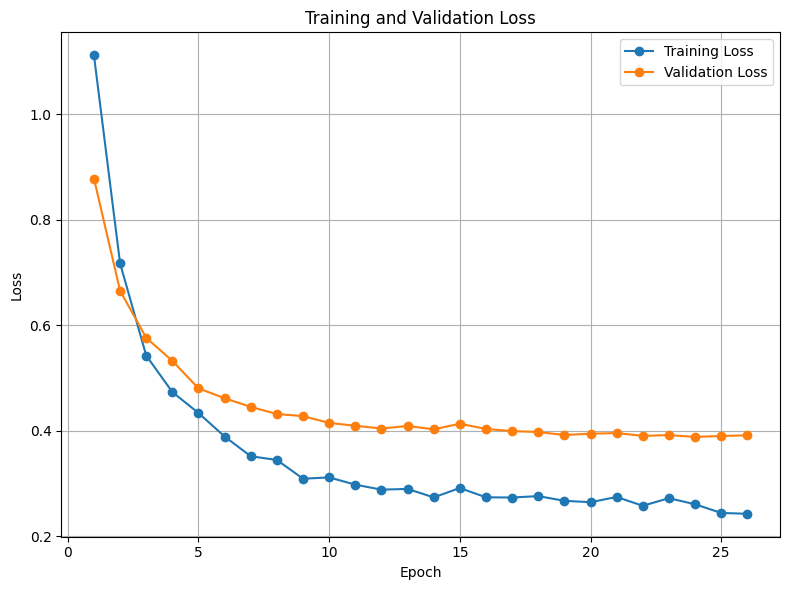

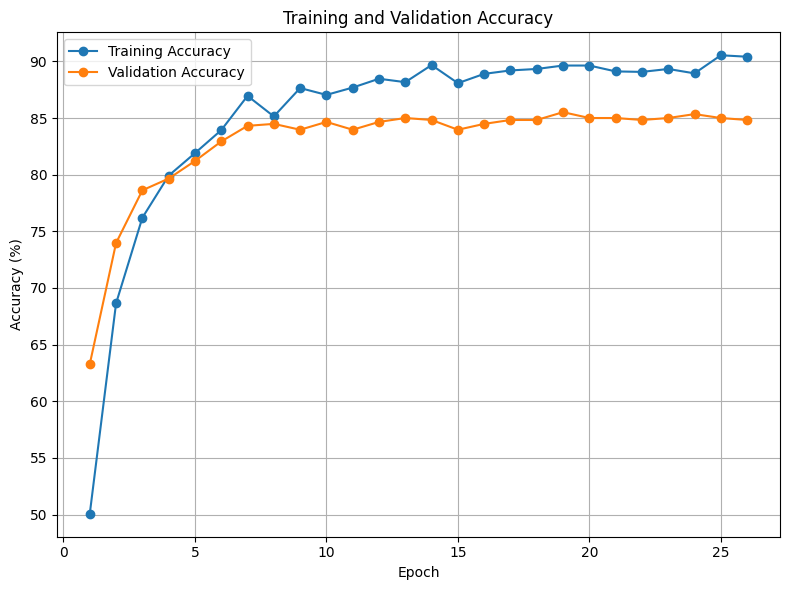

In [6]:
epochs = 50
learning_rate = 2e-4

model = get_model()
optimizer = optim.Adam([
    {'params': model.fc.parameters(), 'lr': learning_rate},
    {'params': model.layer4.parameters(), 'lr': learning_rate/10},
    {'params': model.layer3.parameters(), 'lr': learning_rate/20}
], weight_decay=1e-4)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)

class_weights = get_class_weights(class_counts)
criterion = nn.CrossEntropyLoss(weight=class_weights)

train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, optimizer, scheduler, epochs, criterion)
torch.save(model, 'cold_model.pth')

loss_acc_plot(train_losses, val_losses, train_accs, val_accs)

Loading: 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


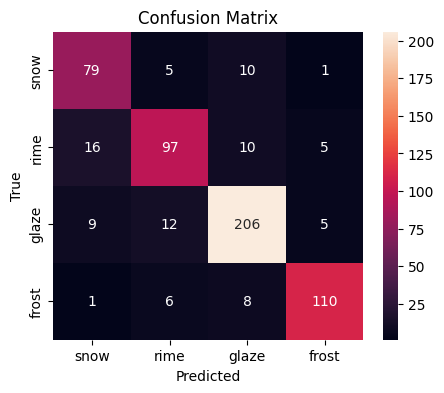

In [9]:
labels, preds, probs = get_predictions_and_probs(model, val_loader)

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(5, 4))
sb.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Precision and Recall:
Macro Precision: 0.8375
Macro Recall: 0.8393
Weighted Precision: 0.8497
Weighted Recall: 0.8483

Per-class Metrics:
              precision    recall  f1-score   support

       frost       0.75      0.83      0.79        95
       glaze       0.81      0.76      0.78       128
        rime       0.88      0.89      0.88       232
        snow       0.91      0.88      0.89       125

    accuracy                           0.85       580
   macro avg       0.84      0.84      0.84       580
weighted avg       0.85      0.85      0.85       580


AUC Scores:
AUC for frost: 0.9686
AUC for glaze: 0.9535
AUC for rime: 0.9631
AUC for snow: 0.9714
Macro-average AUC: 0.9641
Micro-average AUC: 0.9665


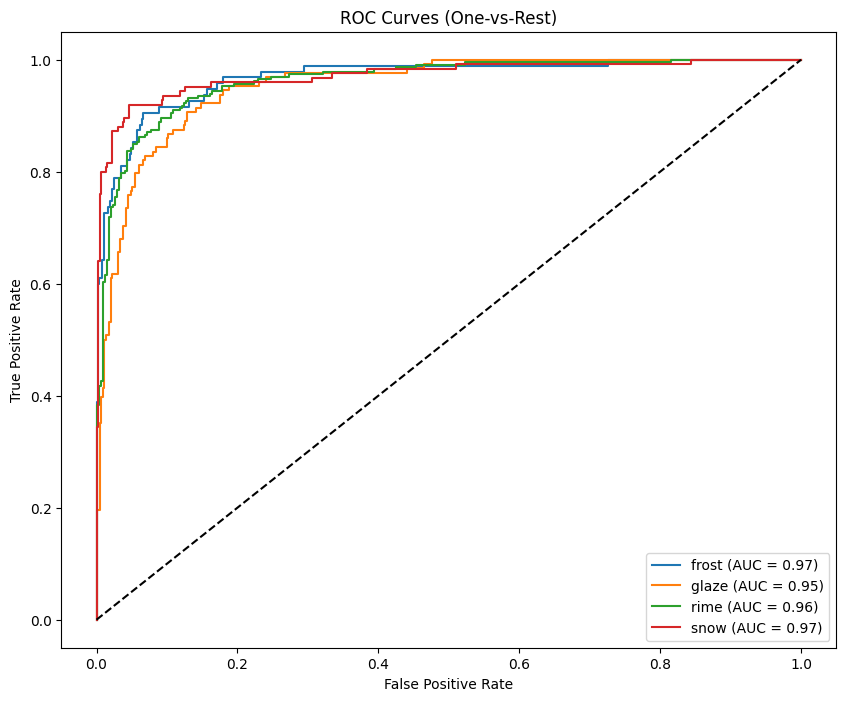

In [8]:
# Precision and Recall
print("Precision and Recall:")
print(f"Macro Precision: {precision_score(labels, preds, average='macro'):.4f}")
print(f"Macro Recall: {recall_score(labels, preds, average='macro'):.4f}")
print(f"Weighted Precision: {precision_score(labels, preds, average='weighted'):.4f}")
print(f"Weighted Recall: {recall_score(labels, preds, average='weighted'):.4f}")
print("\nPer-class Metrics:")
print(classification_report(labels, preds, target_names=original_dataset.classes))

# AUC
labels_bin = label_binarize(labels, classes=range(num_classes))
auc_per_class = [roc_auc_score(labels_bin[:, i], probs[:, i]) for i in range(num_classes)]
macro_auc = roc_auc_score(labels_bin, probs, average='macro', multi_class='ovr')
micro_auc = roc_auc_score(labels_bin.ravel(), probs.ravel())

print("\nAUC Scores:")
for i, auc in enumerate(auc_per_class):
    print(f"AUC for {original_dataset.classes[i]}: {auc:.4f}")
print(f"Macro-average AUC: {macro_auc:.4f}")
print(f"Micro-average AUC: {micro_auc:.4f}")

# ROC Curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(labels_bin[:, i], probs[:, i])
    plt.plot(fpr, tpr, label=f'{original_dataset.classes[i]} (AUC = {auc_per_class[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='best')
plt.show()